In [1]:
# %matplotlib widget
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from qokit.parameter_utils import get_fixed_gamma_beta

# rc('font',**{'family':'serif','serif':['Times New Roman'],'size':16})
# rc('text', usetex=True)

method = "LN_COBYLA (NLopt)"
problem = "po"
p = 5
n = 12
seed_pool = list(range(60)) if problem == "po" else list(range(1000))

data = pickle.load(
    open(
        f"data/{problem}/configs/max_ar/LN_COBYLA (NLopt)-p{p}-q{n}-s0-{59 if problem == 'po' else 999}.pckl",
        "rb",
    ),
)
gamma, beta = get_fixed_gamma_beta(3, p)
optimal_params = data["optimal_params"] - np.concatenate([gamma, [b * 4 for b in beta]])
max_ar = data["result"][:len(seed_pool),np.newaxis,np.newaxis]

data = pickle.load(
    open(
        f"data/{problem}/configs/budget/{method}-p{p}-q{n}-s{seed_pool[0]}-{seed_pool[-1]}.pckl",
        "rb",
    ),
)
config = data["config"]
result = data["result"][:,:,:]
initial_ar = np.array(data["initial_ar"])[:,np.newaxis,np.newaxis]

print(config, result.shape)
shots_pool = [d["shots"] for d in config["executor_kwargs"]][:]
maxfev_pool = config["maxeval"][:]


{'initial_point': [array([ 1.082 ,  1.9216,  2.0296,  2.2584,  2.5588, -4.7192, -3.5936,
       -2.8472, -2.1144, -1.1888])], 'maxeval': [12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50], 'initial_step': [0.2], 'ftol_rel': [1e-13], 'executor_kwargs': [{'shots': 833}, {'shots': 769}, {'shots': 714}, {'shots': 666}, {'shots': 625}, {'shots': 588}, {'shots': 555}, {'shots': 526}, {'shots': 500}, {'shots': 400}, {'shots': 333}, {'shots': 285}, {'shots': 250}, {'shots': 222}, {'shots': 200}]} (60, 15, 15)


In [2]:
result = (result - initial_ar) / (max_ar - initial_ar)
# result = result[((max_ar - initial_ar) < 0.05).flat]
print(result.shape)

print((initial_ar.flatten() - max_ar.flatten())[:10])
print(np.sort((max_ar - initial_ar).flat)[-1:-6:-1])


(60, 15, 15)
[-0.14532619 -0.08356357 -0.08525842 -0.02964335 -0.03069615 -0.05808315
 -0.11775833 -0.13374842 -0.03188462 -0.05987876]
[0.1566478  0.14962154 0.14532619 0.14447331 0.14096757]


Text(0.5, 1.0, 'po p=5 n=12')

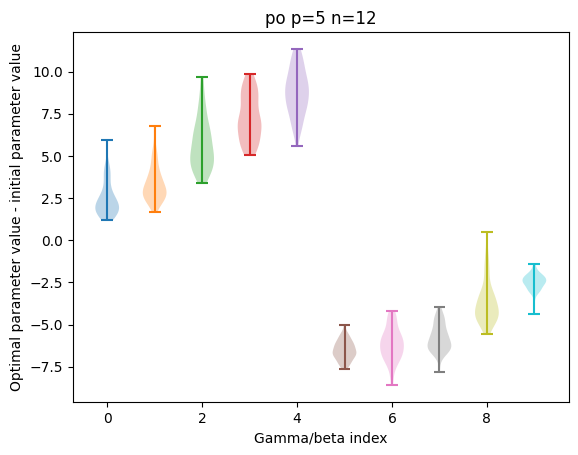

In [3]:
plt.figure()
for i in range(2 * p):
    plt.violinplot(optimal_params[:,i], [i])
# plt.ylim(0, np.pi)
plt.ylabel("Optimal parameter value - initial parameter value")
plt.xlabel("Gamma/beta index")
plt.title(f"{problem} {p=} {n=}")


In [4]:
# print("Initial AR:", np.mean(initial_ar))
mean_ar = np.mean(result, axis=0)
indices = np.argsort(mean_ar.flat)[-1:-100:-1]
for r, c in zip(mean_ar.flatten()[indices], config.interpret(indices)):
    print(r, c)


0.0674299442170844 ['maxeval=30', "executor_kwargs={'shots': 666}"]
0.06662637676559088 ['maxeval=18', "executor_kwargs={'shots': 769}"]
0.06538039982274589 ['maxeval=15', "executor_kwargs={'shots': 833}"]
0.06496866296816992 ['maxeval=25', "executor_kwargs={'shots': 833}"]
0.06365525707259678 ['maxeval=35', "executor_kwargs={'shots': 833}"]
0.06344906025737622 ['maxeval=12', "executor_kwargs={'shots': 769}"]
0.06279667134164858 ['maxeval=40', "executor_kwargs={'shots': 769}"]
0.06166837259490996 ['maxeval=45', "executor_kwargs={'shots': 666}"]
0.06083191965586089 ['maxeval=45', "executor_kwargs={'shots': 769}"]
0.059952009223863435 ['maxeval=17', "executor_kwargs={'shots': 714}"]
0.059692564412142435 ['maxeval=13', "executor_kwargs={'shots': 769}"]
0.05939515504178736 ['maxeval=18', "executor_kwargs={'shots': 833}"]
0.05922275563418059 ['maxeval=13', "executor_kwargs={'shots': 714}"]
0.05921236159673697 ['maxeval=50', "executor_kwargs={'shots': 588}"]
0.05878131116131222 ['maxeval=25'

Text(0.5, 0, 'relative AR improvement')

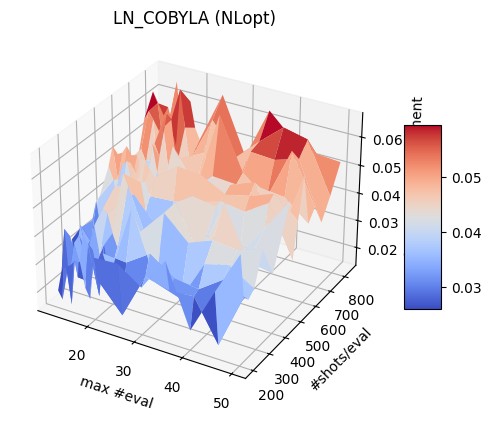

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(maxfev_pool, shots_pool, indexing='ij')
z = np.mean(result, axis=0)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
# ax.plot_surface(x, y, np.ones_like(z) * np.mean(initial_ar), cmap=cm.coolwarm, linewidth=0, antialiased=True, rstride=1, cstride=1, edgecolor='none')
ax.set_title(method)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_ylabel('#shots/eval')
ax.set_xlabel('max #eval')
ax.set_zlabel('relative AR improvement')
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}-3d.png")


Text(0.5, 1.0, 'po p=5 n=12')

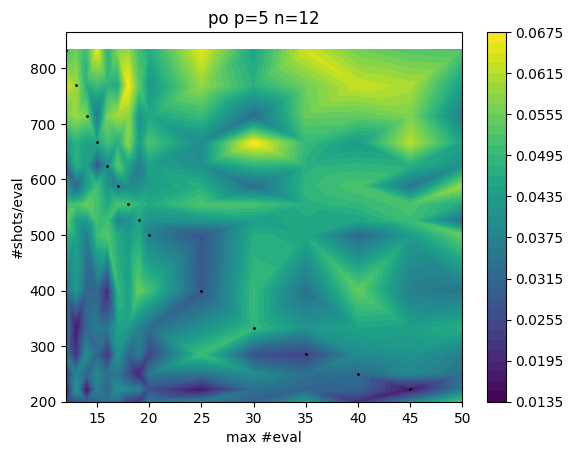

In [6]:
budget = 10000

plt.figure()
x, y = np.meshgrid(maxfev_pool, shots_pool, indexing='ij')
z = np.mean(result, axis=0)
fig = plt.tricontourf(x.flat, y.flat, z.flat, levels=50)
plt.plot(maxfev_pool, budget / np.array(maxfev_pool), "ko", ms=1)
plt.colorbar(fig)
plt.xlabel('max #eval')
plt.ylabel('#shots/eval')
plt.title(f"{problem} {p=} {n=}")
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}.png")


Text(0.5, 1.0, 'po p=5 n=12')

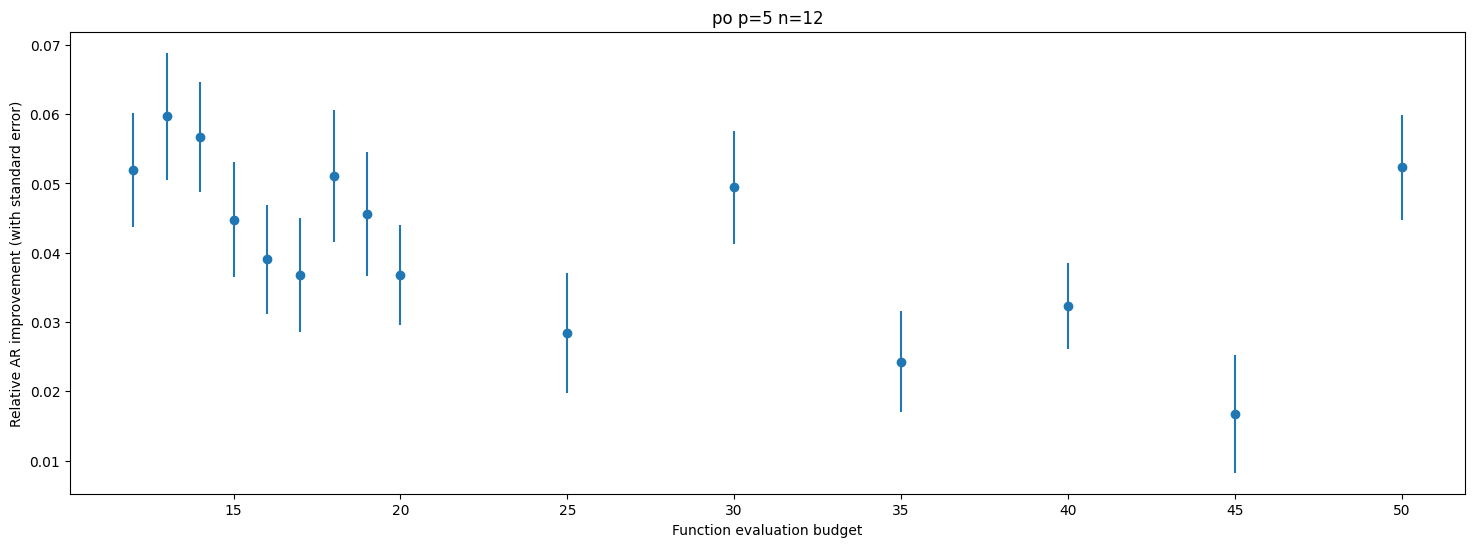

In [7]:
plt.figure(figsize=(18, 6))
# plt.violinplot(
#     [result[:, j, j] for j in range(len(shots_pool))],
#     maxfev_pool,
#     widths=1,
#     showmeans=True,
#     quantiles=[[0.25, 0.75]] * len(shots_pool),
# )
# plt.ylim([0, 1])
plt.errorbar(
    maxfev_pool,
    [np.mean(result, axis=0)[i, i] for i in range(len(shots_pool))],
    yerr=[np.std(result[:, i, i]) / np.sqrt(result.shape[0]) for i in range(len(shots_pool))],
    fmt="o",
)
plt.ylabel("Relative AR improvement (with standard error)")
plt.xlabel("Function evaluation budget")
plt.title(f"{problem} {p=} {n=}")
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}-slice.png")


11
9
6
2
2
4
9
4
4


ValueError: zero-size array to reduction operation minimum which has no identity

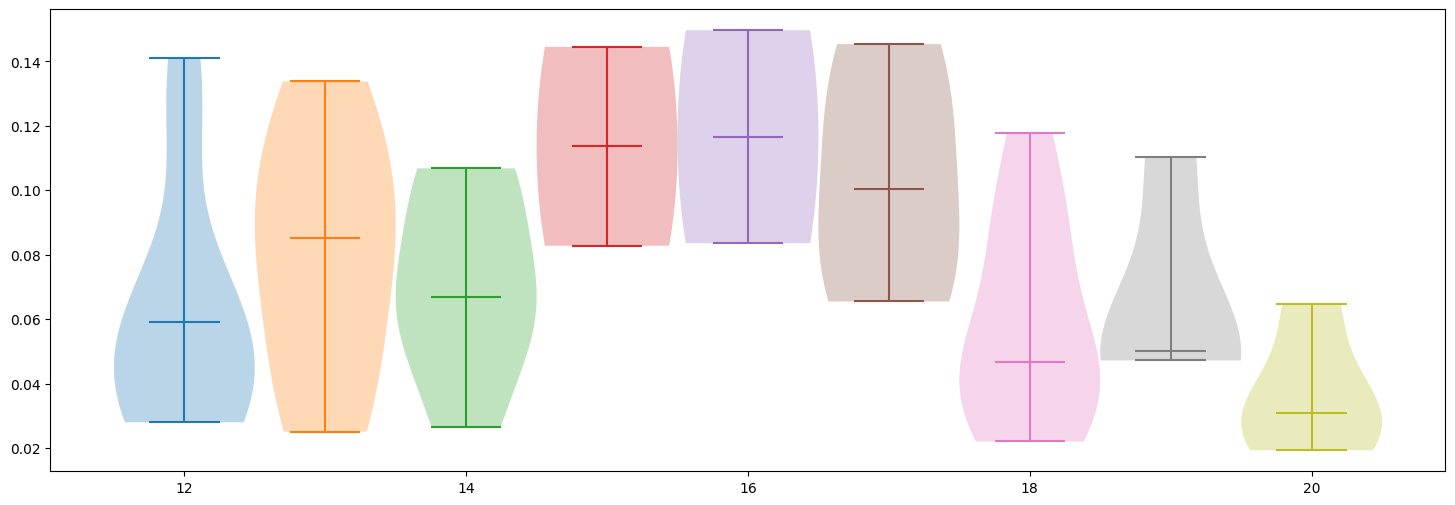

In [8]:
plt.figure(figsize=(18, 6))
for i, fev in enumerate(maxfev_pool):
    slice = np.array([result[:, j, j] for j in range(len(shots_pool))])
    ar_diff = (max_ar - initial_ar).flat[
        np.argmax(slice >= slice.max(axis=0) * 0.9, axis=0) == i
    ]
    plt.violinplot(
        ar_diff,
        [fev],
        widths=1,
        showmedians=True,
        # quantiles=[[0.25, 0.75]],
    )
    # plt.plot(
    #     fev,
    #     np.median(ar_diff),
    #     # yerr=np.std(ar_diff) / np.sqrt(len(ar_diff)),
    #     label=f"{fev=}",
    #     # fmt="o",
    #     marker="o"
    # )
    print(len(ar_diff))
    if i == len(maxfev_pool) - 1:
        print(ar_diff)
        print(slice.T[np.argmax(slice >= slice.max(axis=0), axis=0) == i])
plt.ylabel("AR range")
plt.xlabel("Function evaluation budget")
plt.title(f"{problem} {p=} {n=}")
# plt.ylim([0, 0.06])


Text(0, 0.5, 'AR range')

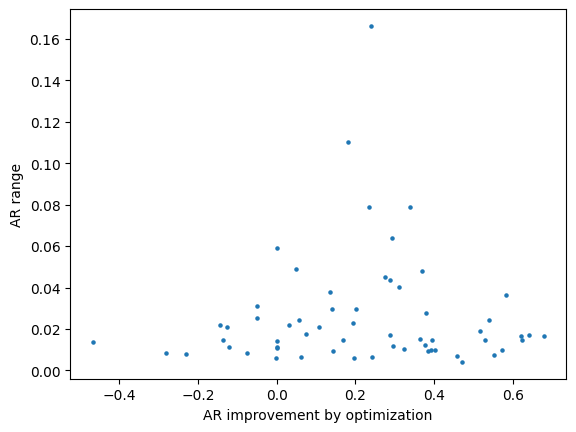

In [ ]:
plt.figure()
plt.scatter(result[:60,1,1], (max_ar - initial_ar).flat[:60], s=5)
plt.xlabel("AR improvement by optimization")
plt.ylabel("AR range")


In [ ]:
sorted_seeds = np.argsort(result[:,1,1])[-1::-1]
selected_seeds = sorted_seeds[np.isin(sorted_seeds, np.arange(1000)[np.where(np.abs((max_ar - initial_ar).flatten() - 0.05) < 0.015)])]
print(selected_seeds)
print(result[selected_seeds,1,1])
print((max_ar - initial_ar).flat[selected_seeds])


[21 45 54 41 34 29 56  9  5 57 40 42 28 19 59 16 43]
[ 0.06010185  0.0478899   0.04487388  0.03032051  0.0279563   0.02715365
  0.02535064  0.01949088  0.01478811  0.01307058  0.01016627  0.00299397
 -0.00255691 -0.00429043 -0.03284356 -0.0332142  -0.07902916]
[0.05868636 0.05916867 0.0472084  0.03872388 0.0407888  0.0444297
 0.05872789 0.06011006 0.05806511 0.05738486 0.06175417 0.05202276
 0.06486878 0.04341174 0.04829523 0.04639676 0.03917985]


In [ ]:
print(np.argsort(result[:,0,0] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,1,1] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,2,2] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,3,3] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,4,4] - initial_ar.flat)[-1:-10:-1])


[ 7 55 20 53 11 10  0 50 37]
[ 7 55 37 50 20 53 11  0 47]
[ 7 55  0 11 20 37 47 12 10]
[ 7 55 11  0 50 20 47 37 12]
[ 7 55 11 20 47 32 37 12  0]


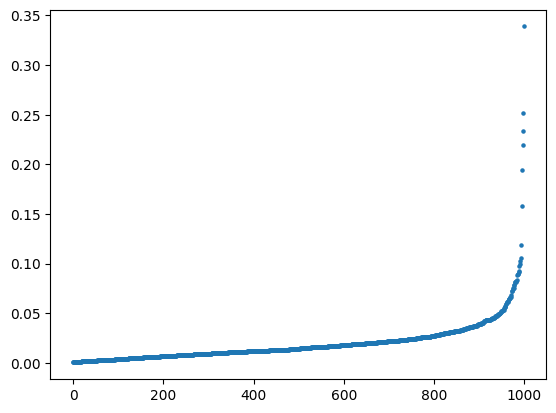

In [ ]:
plt.figure()
plt.scatter(range(1000), np.sort((max_ar - initial_ar).flat), s=5)


In [ ]:
xx = [11, 12, 14, 16, 20]
yy = [900, 800, 700, 600, 500]
zz = [z[0,7], z[2,6], z[4,5], z[8,4]]
zz = [z[0,8], z[1,7], z[3,6], z[5,5], z[9,4]]
zz = [z[i, i] for i in range(len(shots_pool))]
print(zz)


[0.1641994701218559, 0.1498850872342797, 0.13063953189897473, 0.13565727958185284, 0.11402204952509432, 0.11840735918195203, 0.08916160798395661, 0.10388720043365811, 0.06953981248694684, 0.06766277222210025, 0.060385457007876606, 0.04753195131317291]
